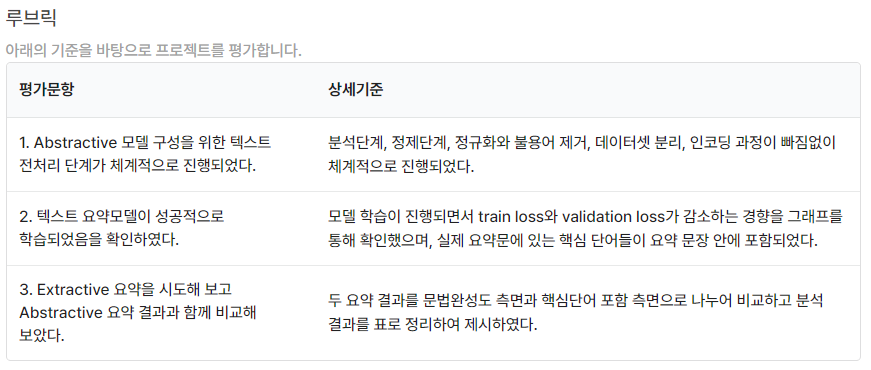

# 12-13. 프로젝트: 뉴스기사 요약해보기


새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져봐요.

먼저 주요 라이브러리 버전을 확인해 보죠.

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa

print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

3.6.5
2.6.0
1.2.0


In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aeoli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=3


## Step 1. 데이터 수집하기


데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

- [sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)
아래의 코드로 데이터를 다운로드할 수 있어요.

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)

headlines  \
10134  Ibrahimovic beats Rooney to become MLS Newcome...   
30220  Patanjali accounts for 3% of India's food proc...   
7550   Will discuss 'uncontrollable' arms race with R...   
4727   J&K governor inaugurates Vaishno Devi-Bhairon ...   
32782  US President Trump nominated for Nobel Peace P...   
11884  NASA's 28-yr-old Hubble telescope active again...   
28127  I'm not afraid: Teacher suspended over row wit...   
17019  Saudi wealth fund invests $1 bn in Tesla rival...   
33425    North Korea to unify time zone with South Korea   
20835  Won't accept Netaji's ashes from Japan without...   

                                                    text  
10134  Former Manchester United forward Zlatan Ibrahi...  
30220  Patanjali Ayurved's Managing Director Acharya ...  
7550   US President Donald Trump has said that the US...  
4727   Jammu and Kashmir Governor Satya Pal Malik on ...  
32782  A group of Republican lawmakers has formally n...  
11884  NASA's 28-year-old Hubble Space Telescope has ...  
28127  Uttara Bahuguna, the teacher who was suspended...  
17019  Saudi ArabiaÃ¢ÂÂs sovereign wealth fund on M...  
33425  North Korean leader Kim Jong-un has said he wo...  
20835  Netaji Subhas Chandra Bose's grandnephew CK Bo...

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

## Step 2. 데이터 전처리하기 (추상적 요약)


실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

In [6]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [7]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 정규화 및 불용어 제거

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [12]:
data.shape

(98360, 2)

In [13]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [14]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_summary[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [15]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [16]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [17]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


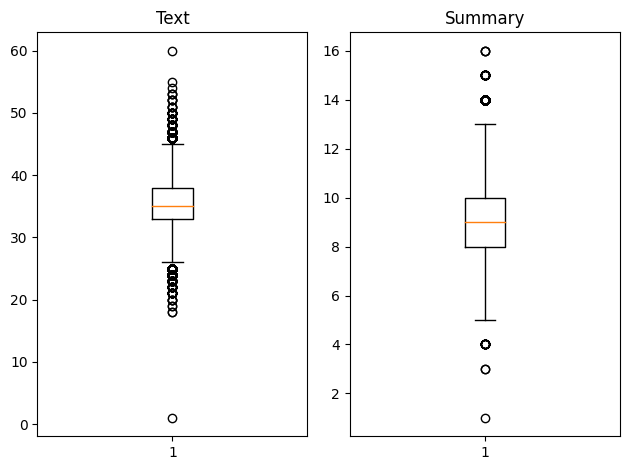

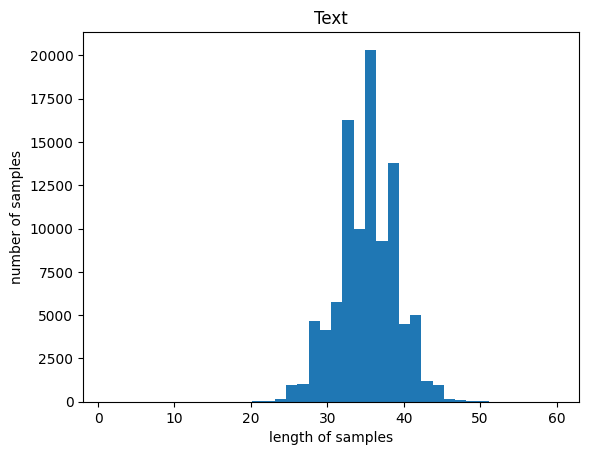

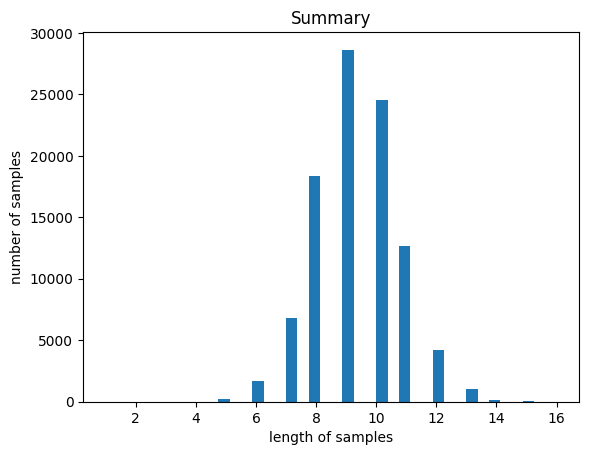

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [44]:
text_max_len = np.max(text_len)
summary_max_len = np.max(summary_len)

print(text_max_len)
print(summary_max_len)

60
16


### 시작토큰 종료토큰 추가

In [19]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

headlines  \
0  upgrad learner switches to career in ml al wit...   
1  delhi techie wins free food from swiggy for on...   
2  new zealand end rohit sharma led india match w...   
3  aegon life iterm insurance plan helps customer...   
4  have known hirani for yrs what if metoo claims...   

                                                text  \
0  saurav kant alumnus upgrad iiit pg program mac...   
1  kunal shah credit card bill payment platform c...   
2  new zealand defeated india wickets fourth odi ...   
3  aegon life iterm insurance plan customers enjo...   
4  speaking sexual harassment allegations rajkuma...   

                                       decoder_input  \
0  sostoken upgrad learner switches to career in ...   
1  sostoken delhi techie wins free food from swig...   
2  sostoken new zealand end rohit sharma led indi...   
3  sostoken aegon life iterm insurance plan helps...   
4  sostoken have known hirani for yrs what if met...   

                                      decoder_target  
0  upgrad learner switches to career in ml al wit...  
1  delhi techie wins free food from swiggy for on...  
2  new zealand end rohit sharma led india match w...  
3  aegon life iterm insurance plan helps customer...  
4  have known hirani for yrs what if metoo claims...

In [20]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


### 데이터 셔플 및 훈련, 발리데이션 데이터와 테스트 데이터 생성

In [21]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[69489 61630 37134 ... 69156 83234 14670]


In [22]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [24]:
n_of_val = int(len(encoder_input)*0.2)
n_of_test = int(len(encoder_input)*0.1)
print('validation 데이터의 수 :', n_of_val)
print('테스트 데이터의 수 :', n_of_test)

validation 데이터의 수 : 19672
테스트 데이터의 수 : 9836


In [26]:
encoder_input_train = encoder_input[:-(n_of_val + n_of_test)]
decoder_input_train = decoder_input[:-(n_of_val + n_of_test)]
decoder_target_train = decoder_target[:-(n_of_val + n_of_test)]

encoder_input_val = encoder_input[-(n_of_val + n_of_test): -n_of_test]
decoder_input_val = decoder_input[-(n_of_val + n_of_test): -n_of_test]
decoder_target_val = decoder_target[-(n_of_val + n_of_test): -n_of_test]

encoder_input_test = encoder_input[-n_of_test:]
decoder_input_test = decoder_input[-n_of_test:]
decoder_target_test = decoder_target[-n_of_test:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('평가 데이터의 개수 :', len(encoder_input_val))
print('평가 레이블의 개수 :', len(decoder_input_val))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68852
훈련 레이블의 개수 : 68852
평가 데이터의 개수 : 19672
평가 레이블의 개수 : 19672
테스트 데이터의 개수 : 9836
테스트 레이블의 개수 : 9836


In [27]:
print(len(encoder_input_train)+len(encoder_input_val)+len(encoder_input_test))

98360


### 정수 인코딩

In [28]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [29]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 65850
등장 빈도가 6번 이하인 희귀 단어의 수: 45006
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20844
단어 집합에서 희귀 단어의 비율: 68.34624145785877
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.7882893803779316


In [30]:
src_vocab = 21000
src_tokenizer = Tokenizer(num_words=src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)
print('=3')

=3


In [31]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_val = src_tokenizer.texts_to_sequences(encoder_input_val)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])
print('-' * 30)
print(encoder_input_val[:3])
print('-' * 30)
print(encoder_input_test[:3])

[[1850, 196, 25, 831, 1707, 5241, 1406, 737, 2401, 960, 565, 1850, 960, 950, 1140, 7512, 1643, 1406, 36, 2792, 28, 3140, 1406, 9927, 83, 285, 105, 992, 228, 101, 13726, 1406], [66, 1668, 214, 1114, 341, 478, 5073, 777, 5242, 5243, 19440, 52, 234, 662, 72, 143, 121, 4785, 16344, 5243, 474, 594, 77, 79, 166, 6547, 72, 293, 28, 255, 6547, 14889, 16344, 20845, 31, 1], [2, 5, 1449, 7, 731, 492, 2564, 5, 21, 425, 2596, 4279, 437, 425, 1556, 4875, 1141, 731, 3802, 11, 7893, 1115, 587, 14, 1878, 1443, 437, 14, 2729, 2346, 731, 1784, 11282, 3101, 132, 437, 2370, 12, 704]]
------------------------------
[[26, 4189, 17845, 13635, 390, 284, 12861, 12058, 141, 435, 1412, 218, 643, 335, 240, 19235, 121, 13635, 1792, 117, 987, 12759, 5335, 2068, 855, 271, 284, 4573, 2082, 371, 4067, 1736, 1412, 89], [275, 834, 3058, 8061, 282, 1353, 3622, 1085, 2, 282, 1043, 1013, 1592, 2524, 3622, 244, 67, 12, 23, 1144, 187, 2073, 1659, 3458, 492, 934, 2612, 413, 1167, 383, 3724, 2], [375, 10543, 2169, 285, 737, 871

In [32]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [34]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28757
등장 빈도가 6번 이하인 희귀 단어의 수: 19946
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8811
단어 집합에서 희귀 단어의 비율: 69.36050352957541
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.881987893011684


In [35]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_val = tar_tokenizer.texts_to_sequences(decoder_input_val) 
decoder_target_val = tar_tokenizer.texts_to_sequences(decoder_target_val)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 973, 5183, 2318, 169, 3155, 987, 5, 2235], [1, 124, 88, 21, 3088, 359, 1381, 298, 7051, 3, 295], [1, 8, 13, 3, 811, 439, 4, 1817], [1, 109, 77, 2236, 3, 480, 2726, 570, 79, 7052], [1, 694, 418, 3, 1057, 923, 1539, 1124, 2237, 1679, 8813, 656]]
target
decoder  [[973, 5183, 2318, 169, 3155, 987, 5, 2235, 2], [124, 88, 21, 3088, 359, 1381, 298, 7051, 3, 295, 2], [8, 13, 3, 811, 439, 4, 1817, 2], [109, 77, 2236, 3, 480, 2726, 570, 79, 7052, 2], [694, 418, 3, 1057, 923, 1539, 1124, 2237, 1679, 8813, 656, 2]]


In [40]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_val = [index for index, sentence in enumerate(decoder_input_val) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 val 데이터의 개수 :', len(drop_val))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 val 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


In [41]:
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

In [42]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('val 데이터의 개수 :', len(encoder_input_val))
print('val 레이블의 개수 :', len(decoder_input_val))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68851
훈련 레이블의 개수 : 68851
val 데이터의 개수 : 19672
val 레이블의 개수 : 19672
테스트 데이터의 개수 : 9836
테스트 레이블의 개수 : 9836


### 패딩

In [45]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_val = pad_sequences(encoder_input_val, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_val = pad_sequences(decoder_input_val, maxlen=summary_max_len, padding='post')
decoder_target_val = pad_sequences(decoder_target_val, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)


일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

### 모델 설계하기
1. 인코더 모델 설계

In [59]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 256
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

2. 디커더 설계

In [60]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

3. 출력층 및 모델 정의
    - 어텐션 메커니즘을 통한 디코더 설계

In [61]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 60, 256)      5376000     input_5[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 60, 256), (N 525312      embedding_4[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련

In [62]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_val, decoder_input_val], decoder_target_val), \
          batch_size=128, callbacks=[es], epochs=70)

Epoch 1/70
538/538 [==============================] - 24s 41ms/step - loss: 4.0727 - val_loss: 3.7035
Epoch 2/70
538/538 [==============================] - 21s 39ms/step - loss: 3.5798 - val_loss: 3.4174
Epoch 3/70
538/538 [==============================] - 21s 39ms/step - loss: 3.3424 - val_loss: 3.2572
Epoch 4/70
538/538 [==============================] - 21s 39ms/step - loss: 3.1720 - val_loss: 3.1430
Epoch 5/70
538/538 [==============================] - 21s 39ms/step - loss: 3.0362 - val_loss: 3.0512
Epoch 6/70
538/538 [==============================] - 21s 39ms/step - loss: 2.9214 - val_loss: 2.9834
Epoch 7/70
538/538 [==============================] - 21s 39ms/step - loss: 2.8222 - val_loss: 2.9323
Epoch 8/70
538/538 [==============================] - 21s 39ms/step - loss: 2.7339 - val_loss: 2.8851
Epoch 9/70
538/538 [==============================] - 21s 39ms/step - loss: 2.6585 - val_loss: 2.8473
Epoch 10/70
538/538 [==============================] - 21s 40ms/step - loss: 2.588

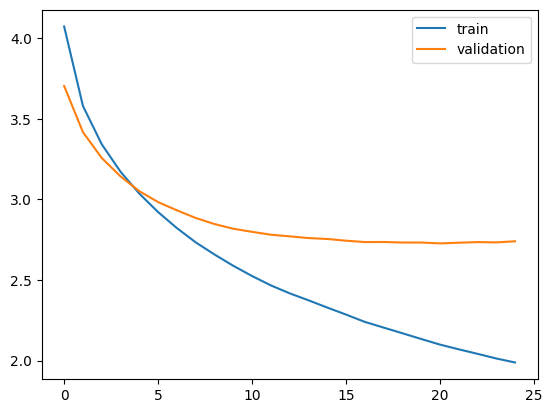

In [63]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

### 인퍼런스 구현

In [64]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [65]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [66]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [67]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)


원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [68]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [70]:
for i in (22, 33, 111, 2222, 5555):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : former australian pacer brett lee said year old son favourite cricketer indian skipper virat kohli kohli walked past shook hands told son favourite batsman kohli showed great gesture gave son one test shirts signed best wishes kohli said lee 
실제 요약 : virat kohli is my son favourite cricketer brett lee 
예측 요약 :  kohli reveals he is father of his son


원문 : silicon valley based big data startup data secured million series funding round led us based vc firm capital microsoft ventures menlo ventures also participated funding round data said statement founded startup helps companies accelerate performance big data applications clusters 
실제 요약 : silicon valley big data startup raises million 
예측 요약 :  data startup raises million


원문 : australia based study fossils early humans discovered indonesia revealed likely evolved ancestor africa existing lakh years ago species dubbed due small stature researchers said discovery previous beliefs related researchers added 
실제 요약 : scientists reve

## Step 5. Summa을 이용해서 추출적 요약해보기


추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [71]:
import requests
from summa.summarizer import summarize

In [105]:
text = """Automatic summarization is the process of reducing a text document with a \
computer program in order to create a summary that retains the most important points \
of the original document. As the problem of information overload has grown, and as \
the quantity of data has increased, so has interest in automatic summarization. \
Technologies that can make a coherent summary take into account variables such as \
length, writing style and syntax. An example of the use of summarization technology \
is search engines such as Google. Document summarization is another."""


print(summarize(text))

Automatic summarization is the process of reducing a text document with a computer program in order to create a summary that retains the most important points of the original document.


SyntaxError: invalid syntax (2079808272.py, line 1)

In [112]:
sentence = '''silicon valley based big data startup data secured million series funding round \
led us based vc firm capital microsoft ventures menlo ventures also participated funding round data said statement founded startup helps companies accelerate performance big data applications clusters'''

In [111]:
print(sentence)

silicon valley based big data startup data secured million series funding round led us based vc firm capital microsoft ventures menlo ventures also participated funding round data said statement founded startup helps companies accelerate performance big data applications clusters.


In [108]:
# text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [109]:
print('Summary:')
print(summarize(sentence, split=True))

Summary:
[]


In [110]:
summarize(sentence)

''

In [87]:
for i in (22, 33, 111, 2222, 5555):
    sentence = seq2text(encoder_input_test[i])
    print("원문 :", sentence)
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("추출적 요약 :", summarize(sentence, ratio=0.35))
    print("\n")

원문 : former australian pacer brett lee said year old son favourite cricketer indian skipper virat kohli kohli walked past shook hands told son favourite batsman kohli showed great gesture gave son one test shirts signed best wishes kohli said lee 
실제 요약 : virat kohli is my son favourite cricketer brett lee 
예측 요약 :  kohli reveals he is father of his son
추출적 요약 : 


원문 : silicon valley based big data startup data secured million series funding round led us based vc firm capital microsoft ventures menlo ventures also participated funding round data said statement founded startup helps companies accelerate performance big data applications clusters 
실제 요약 : silicon valley big data startup raises million 
예측 요약 :  data startup raises million
추출적 요약 : 


원문 : australia based study fossils early humans discovered indonesia revealed likely evolved ancestor africa existing lakh years ago species dubbed due small stature researchers said discovery previous beliefs related researchers added 
실제 